In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
!pip install torch torchvision feather-format kornia pyarrow 
!pip install git+https://github.com/fastai/fastai

  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-ej9fhn1k
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-ej9fhn1k
  Created wheel for fastai: filename=fastai-2.2.8-py3-none-any.whl size=192194 sha256=aafaa3dffe82ddb353500d07e0fa4cd45cbd08d2a79c1dc603d0e71600b27d14
  Stored in directory: /tmp/pip-ephem-wheel-cache-ncf_ngsl/wheels/40/be/4f/b7f2aec4df5712626ceed9f20a8996eb05e31244e57e58d632
Successfully built fastai
  Attempting uninstall: fastai
    Found existing installation: fastai 2.2.5
    Uninstalling fastai-2.2.5:
      Successfully uninstalled fastai-2.2.5


In [3]:
!pip install pydicom

In [18]:
from fastai.basics           import *
from fastai.vision.all       import *
from fastai.medical.imaging  import *

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'
set_seed(42)
set_num_threads(1)

path = Path('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection')
#path_trn = path/'stage_1_train_images'
path_tst = path/'stage_2_test'
path_dest = Path()
path_dest.mkdir(exist_ok=True)

path_inp = Path('../input')
path_test=path_inp/'test-frame'
df_test=pd.read_feather(path_test/'df_test.fth').dropna(subset=['img_pct_window'])
pd.set_option('max_columns',None)
#len(df_test)

#df_test.head(10)


Fix Incorrect RescaleIntercept

In [19]:
repr_flds = ['BitsStored','PixelRepresentation']
df1 = df_test.query('(BitsStored==12) & (PixelRepresentation==0)')
df2 = df_test.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = df_test.query('BitsStored==16')
dfs = L(df1,df2,df3)

In [30]:
df1

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,fname,MultiImagePositionPatient,ImagePositionPatient1,ImagePositionPatient2,MultiImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,img_min,img_max,img_mean,img_std,img_pct_window
0,ID_8bab87943,CT,ID_7d815ecf,ID_03328b1230,ID_34847ca10d,,-125.000000,1.0,1,MONOCHROME2,512,512,0.488281,16,12,11,0,47.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/ID_8bab87943.dcm,1,-5.516021,119.640237,1,0.0,0.0,0.0,0.997564,-0.069756,1,0.488281,1.0,47.0,1.0,80.0,3,2693,459.743519,584.866296,0.160557
3,ID_5be923dc9,CT,ID_f1dca1ad,ID_815b89398e,ID_73d7b6b79f,,-114.184211,1.0,1,MONOCHROME2,512,512,0.458984,16,12,11,0,100.0,600.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/ID_5be923dc9.dcm,1,49.605263,249.000000,1,0.0,0.0,0.0,1.000000,0.000000,1,0.458984,1.0,100.0,1.0,600.0,0,2595,539.577824,564.405776,0.232231
4,ID_a90458b64,CT,ID_7547b481,ID_bfbcb4d29e,ID_663f03f97f,,-118.000000,1.0,1,MONOCHROME2,512,512,0.464844,16,12,11,0,36.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/ID_a90458b64.dcm,1,-2.284210,20.899994,1,0.0,0.0,0.0,1.000000,0.000000,1,0.464844,1.0,36.0,1.0,80.0,0,2461,572.700329,567.955032,0.231243
5,ID_b18ea4888,CT,ID_12e50c67,ID_d3f814c6df,ID_b2227d7e98,,-118.500000,1.0,1,MONOCHROME2,512,512,0.462891,16,12,11,0,40.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/ID_b18ea4888.dcm,1,1.196934,1184.763070,1,0.0,0.0,0.0,0.992546,-0.121869,1,0.462891,1.0,40.0,1.0,80.0,0,2614,571.787769,595.360953,0.319080
9,ID_7a78723f3,CT,ID_73c0c7b7,ID_28f6769948,ID_83ff0244e1,,-159.000000,1.0,1,MONOCHROME2,512,512,0.488281,16,12,11,0,40.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/ID_7a78723f3.dcm,1,-0.469781,159.301742,1,0.0,0.0,0.0,0.997564,-0.069756,1,0.488281,1.0,40.0,1.0,80.0,2,2585,486.673695,608.407091,0.175755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121223,ID_14f86e04a,CT,ID_62497c74,ID_b15050a309,ID_2fb612d1af,,-141.000000,1.0,1,MONOCHROME2,512,512,0.550781,16,12,11,0,36.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/ID_14f86e04a.dcm,1,-76.000000,-118.599991,1,0.0,0.0,0.0,1.000000,0.000000,1,0.550781,1.0,36.0,1.0,80.0,0,2035,261.537689,491.575541,0.025860
121224,ID_51b233923,CT,ID_9f12d695,ID_2738a5b272,ID_14fd218bdd,,-125.000000,1.0,1,MONOCHROME2,512,512,0.488281,16,12,11,0,36.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/ID_51b233923.dcm,1,-71.000000,202.700012,1,0.0,0.0,0.0,1.000000,0.000000,1,0.488281,1.0,36.0,1.0,80.0,4,2278,393.254963,479.376045,0.113918
121226,ID_fb5a9ca9d,CT,ID_c1445e2e,ID_51b7f8d0a6,ID_90f933af9d,,-109.500000,1.0,1,MONOCHROME2,512,512,0.427734,16,12,11,0,36.0,80.0,-1024.0,1.0,../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/ID_fb5a9ca9d.dcm,1,7.500000,168.300049,1,0.0,0.0,0.0,1.000000,0.000000,1,0.427734,1.0,36.0,1.0,80.0,14,2337,619.199677,617.864737,0.304771
121229,ID_39cec1562,CT,ID_12107723,ID_0b1aa8f3ac,ID_23879869a2,,-113.000000,1.0,1,MONOCHROME2,512,512,0.44140

The problematic images are those in df1, which don't have the expected RescaleIntercept of -1024 or similar. We'll grab that subset, and have a look at a few of them


In [27]:
def df2dcm(df): return L(Path(o).dcmread() for o in df.fname.values)

0


IndexError: list index out of range

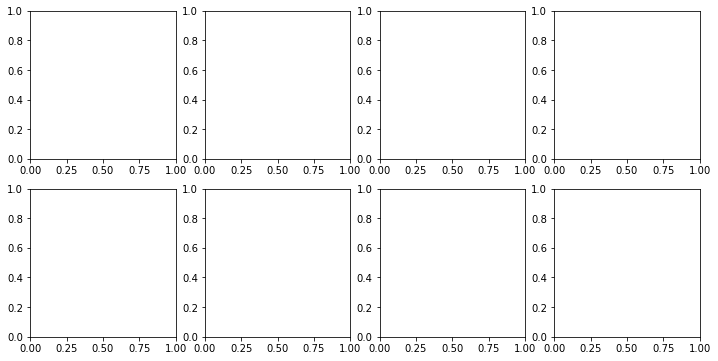

In [32]:
df_iffy = df1[df1.RescaleIntercept>-100]
dcms = df2dcm(df_iffy)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)


In [45]:
df1[df1.RescaleIntercept>-100]

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,Columns,PixelSpacing,BitsAllocated,BitsStored,HighBit,PixelRepresentation,WindowCenter,WindowWidth,RescaleIntercept,RescaleSlope,fname,MultiImagePositionPatient,ImagePositionPatient1,ImagePositionPatient2,MultiImageOrientationPatient,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,MultiPixelSpacing,PixelSpacing1,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,img_min,img_max,img_mean,img_std,img_pct_window


In [46]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

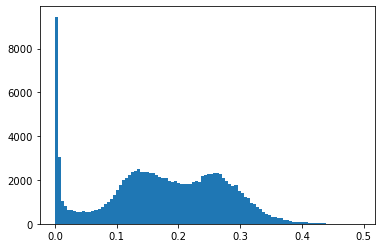

In [50]:
plt.hist(df_test.img_pct_window,100);

There are a lot of images with nearly no brain tissue in them - presumably they're the slices above and below the brain. Let's see if they have any labels:

In [57]:
df_test = df_test.assign(pct_cut = pd.cut(df_test.img_pct_window, [0,0.02,0.05,0.1,0.2,0.3,1]))


In [58]:
df_test.drop(df_test.query('img_pct_window<0.02').index, inplace=True)

In [59]:
len(df_tst)

106887

In [61]:
def pad_square(x):
    r,c = x.shape
    d = (c-r)/2
    pl,pr,pt,pb = 0,0,0,0
    if d>0: pt,pd = int(math.floor( d)),int(math.ceil( d))        
    else:   pl,pr = int(math.floor(-d)),int(math.ceil(-d))
    return np.pad(x, ((pt,pb),(pl,pr)), 'minimum')

def crop_mask(x):
    mask = x.mask_from_blur(dicom_windows.brain)
    bb = mask2bbox(mask)
    if bb is None: return
    lo,hi = bb
    cropped = x.pixel_array[lo[0]:hi[0],lo[1]:hi[1]]
    x.pixel_array = pad_square(cropped)

In [64]:
def get_samples(df):
    recs = [df.sample() ]
    
    return pd.concat(recs).fname.values

sample_fns = concat(*dfs.map(get_samples))
sample_dcms = tuple(Path(o).dcmread().scaled_px for o in sample_fns)
samples = torch.stack(sample_dcms)
bins = samples.freqhist_bins()

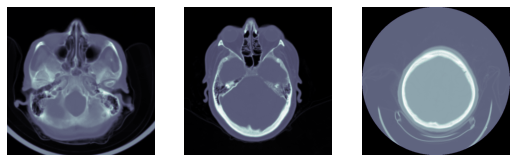

In [94]:
show_images(sample_dcms)

In [147]:
#(path_dest/'bins.pkl').save(bins)

AttributeError: 'PosixPath' object has no attribute 'save'

In [149]:
fns = list(df_test.fname.values)
dest = path_dest/'train_jpg'
dest.mkdir(exist_ok=True)
# NB: Use bs=512 or 1024 when running on GPU
bs=64

dsrc = Datasets(fns, [[dcm_tfm],[os.path.basename]])
dl = TfmdDL(dsrc, bs=bs, num_workers=2)

In [152]:
def dcm_tfm(fn): 
    fn = Path(fn)
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    return x.scaled_px

In [153]:
fns = list(df_test.fname.values)
dest = path_dest/'test_jpg'
dest.mkdir(exist_ok=True)
# NB: Use bs=512 or 1024 when running on GPU
bs=64


dsrc = Datasets(fns, [[dcm_tfm],[os.path.basename]])
dl = TfmdDL(dsrc, bs=bs, num_workers=2)

tensor([-3024., -1006., -1005., -1004., -1003., -1002., -1001., -1000.,  -999.,
         -998.,  -997.,  -996.,  -995.,  -993.,  -991.,  -989.,  -986.,  -982.,
         -978.,  -976.,  -974.,  -973.,  -971.,  -970.,  -968.,  -967.,  -965.,
         -963.,  -962.,  -960.,  -958.,  -955.,  -951.,  -945.,  -937.,  -927.,
         -916.,  -898.,  -870.,  -824.,  -749.,  -658.,  -561.,  -464.,  -362.,
         -263.,  -166.,  -102.,   -88.,   -76.,   -62.,   -46.,   -29.,   -11.,
            5.,    14.,    21.,    24.,    27.,    28.,    30.,    32.,    34.,
           36.,    37.,    40.,    44.,    54.,    81.,   121.,   160.,   202.,
          247.,   290.,   331.,   381.,   469.,   605.,   881.,  1214.,  1476.,
         1661.])

In [154]:
def dest_fname(fname): return dest/Path(fname).with_suffix('.jpg')

def save_cropped_jpg(o, dest):
    fname,px = o
    px.save_jpg(dest_fname(fname), [dicom_windows.brain, dicom_windows.subdural], bins=bins)

In [155]:
def process_batch(pxs, fnames, n_workers=4):
    pxs = to_device(pxs)
    masks = pxs.mask_from_blur(dicom_windows.brain)
    bbs = mask2bbox(masks)
    gs = crop_resize(pxs, bbs, 256).cpu().squeeze()
    parallel(save_cropped_jpg, zip(fnames, gs), n_workers=n_workers, progress=False, dest=dest)

In [156]:
%time process_batch(*dl.one_batch(), n_workers=3)

CPU times: user 9.01 s, sys: 1.32 s, total: 10.3 s
Wall time: 11.1 s


In [158]:
fn = dest.ls()[23]
im = Image.open(fn)
fn

Path('test_jpg/ID_d2f012024.jpg')

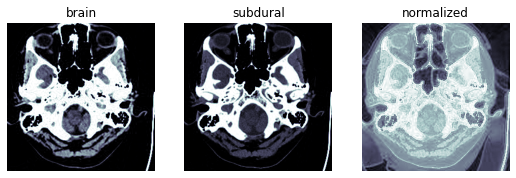

In [160]:
show_images(tensor(im).permute(2,0,1), titles=['brain','subdural','normalized'])

In [161]:
dest.mkdir(exist_ok=True)
for b in progress_bar(dl): process_batch(*b, n_workers=4)


KeyboardInterrupt: 

AttributeError: 'PosixPath' object has no attribute 'jpg16read'

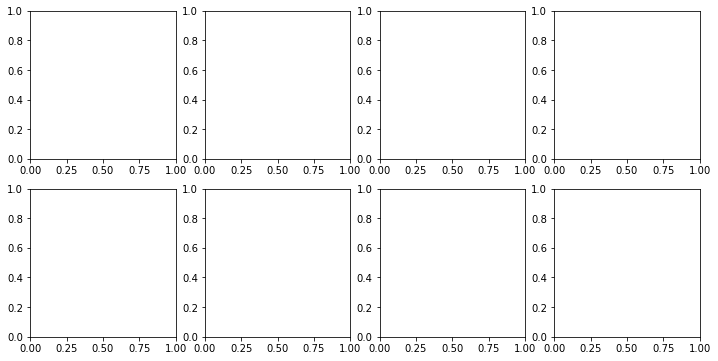

In [139]:
for i,(ax,fn) in enumerate(zip(subplots(2,4)[1].flat,fns)):
    jpgfn = dest/Path(fn).with_suffix('.jpg').name
    a = jpgfn.jpg16read()
    show_image(a,ax=ax)

In [162]:
!tar -zcvf test_jpg.tar.gz /kaggle/working

tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/train_jpg/
/kaggle/working/test_jpg/
/kaggle/working/test_jpg/ID_16b1926c1.jpg
/kaggle/working/test_jpg/ID_b3ddac0c4.jpg
/kaggle/working/test_jpg/ID_240318a03.jpg
/kaggle/working/test_jpg/ID_813a39c18.jpg
/kaggle/working/test_jpg/ID_4dcec3f9f.jpg
/kaggle/working/test_jpg/ID_4534525ab.jpg
/kaggle/working/test_jpg/ID_378fa3d88.jpg
/kaggle/working/test_jpg/ID_9dc3efd73.jpg
/kaggle/working/test_jpg/ID_2f69ac70d.jpg
/kaggle/working/test_jpg/ID_bc6d72aa4.jpg
/kaggle/working/test_jpg/ID_7ffd496c0.jpg
/kaggle/working/test_jpg/ID_80b0c2a42.jpg
/kaggle/working/test_jpg/ID_171cd3acb.jpg
/kaggle/working/test_jpg/ID_ec4a07f67.jpg
/kaggle/working/test_jpg/ID_bcba6c1f6.jpg
/kaggle/working/test_jpg/ID_82edc4c05.jpg
/kaggle/working/test_jpg/ID_f716b9822.jpg
/kaggle/working/test_jpg/ID_c2adaa544.jpg
/kaggle/working/test_jpg/ID_27a963527.jpg
/kaggle/working/test_jpg/ID_0b961d993.jpg
/kaggle/working/test_jpg/ID_87d7ea1b4.jpg
/kag

/kaggle/working/__notebook_source__.ipynb
tar: /kaggle/working: file changed as we read it


In [ ]:
!zip -r test_jpg.zip ./